### Question 1 - setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky

np.random.seed(86)

In [2]:
# Priors
P0, P1 = 0.6, 0.4

# Means
m01 = [-0.9, -1.1];  m02 = [ 0.8,  0.75]
m11 = [-1.1,  0.9];  m12 = [ 0.9, -0.75]

# Covariances for all pairs
C = [[0.75, 0.0],[0.0, 1.25]]

In [3]:
# Create GMM with 2 components using given parameters
def create_gmm(m1, m2, C):
    gmm = GaussianMixture(n_components=2, covariance_type="full")
    gmm.weights_ = np.array([0.5, 0.5])
    gmm.means_ = np.array([m1, m2], dtype=float)
    gmm.covariances_ = np.stack([C, C], axis=0).astype(float)

    gmm.precisions_cholesky_ = _compute_precision_cholesky(gmm.covariances_, 'full')
    gmm.converged_ = True
    gmm.n_features_in_ = 2

    return gmm

# GMMs for P(x|L=0) and P(x|L=1)
gmm0 = create_gmm(m01, m02, C) # 0
gmm1 = create_gmm(m11, m12, C) # 1

In [4]:
# Generate i.i.d sample datasets
def sample_dataset(n):
    y = (np.random.random(n) < P1)  # class labels by priors
    X = np.empty((n, 2))

    n1 = int(y.sum()); 
    n0 = n - n1

    if n0: 
        X[y==0] = gmm0.sample(n0)[0]
    if n1: 
        X[y==1] = gmm1.sample(n1)[0]

    return X, y

# For part 1 and 2
xValidate, yValidate = sample_dataset(10000)

# For part 2
xTrain_50, yTrain_50 = sample_dataset(50)
xTrain_500, yTrain_500 = sample_dataset(500)
xTrain_5k, yTrain_5k = sample_dataset(5000)

### Part 1

In [5]:
# Optimal Decision rule, AKA if s(x) > 0 then L = 1 else 0
scores = gmm1.score_samples(xValidate) + np.log(P1) - (gmm0.score_samples(xValidate) + np.log(P0)) # get s(x)
yhat = (scores > 0).astype(int) # get predicted labels, if s(x) > 0 then decide 1
print(yhat[:10])

# Min Probablity of error on val set
Theo_err = (yhat != yValidate).mean()
print(yValidate[:10]) # true labels

print(f"Theoretical MAP error: {Theo_err:.4f}") # theoretical min error

[1 0 0 0 0 0 0 0 0 0]
[ True  True  True False  True False False False False False]
Theoretical MAP error: 0.2829


In [6]:
# ROC curve from from sklearn, apply s(x) discriminant to the ROC curve
fpr, tpr, thr = roc_curve(yValidate, scores)
print(thr.shape) # get shape

# find min-error point
best_err, best_i = 1, 0
for i, t in enumerate(thr):
    error = ((scores >= t).astype(int) != yValidate).mean()
    if error < best_err: # find min
        best_err, best_i = error, i

print(f"Estimate of the min-P(error) achievable: {best_err:.4f}") # estimated min error

(3706,)
Estimate of the min-P(error) achievable: 0.2811


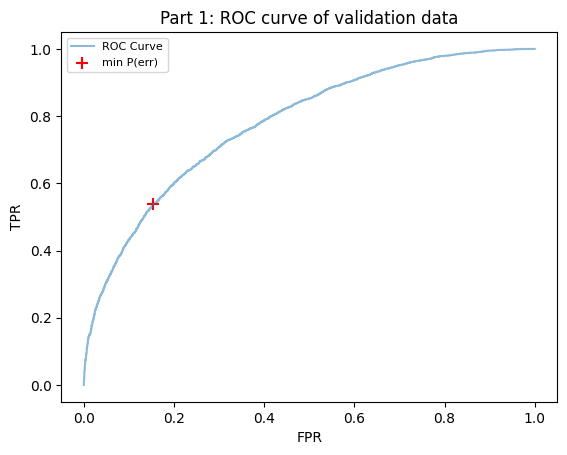

In [7]:
# plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve", alpha=0.5)
plt.scatter([fpr[best_i]], [tpr[best_i]], s=80, c="r", marker="+", label=f"min P(err)")

# format
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Part 1: ROC curve of validation data")
plt.legend(fontsize=8); 
plt.show()

(90000,)
(300, 300)


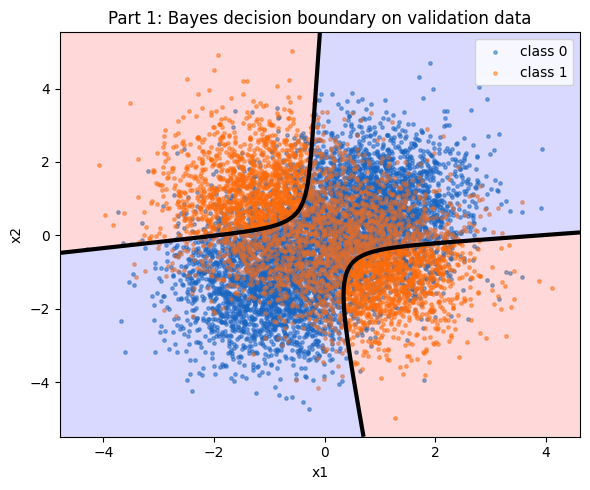

In [ ]:
# Make grid over the validation range
x1 = np.linspace(xValidate[:,0].min()-0.5, xValidate[:,0].max()+0.5, 300)
x2 = np.linspace(xValidate[:,1].min()-0.5, xValidate[:,1].max()+0.5, 300)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)
grid = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

# Bayes score computation for decision boundary
S = gmm1.score_samples(grid) + np.log(P1) - (gmm0.score_samples(grid) + np.log(P0))
print(S.shape)

S = S.reshape(x1_mesh.shape) # reshape into a 300x300 grid
print(S.shape)

# plot data
plt.figure(figsize=(6,5))
plt.scatter(xValidate[yValidate==0,0], xValidate[yValidate==0,1], s=6, alpha=0.5, label="class 0")
plt.scatter(xValidate[yValidate==1,0], xValidate[yValidate==1,1], s=6, alpha=0.5, label="class 1")

# plot decision boundary
plt.contour(x1_mesh, x2_mesh, S, levels=[0.0], linewidths=3, colors='black') # decision boundary
plt.contourf(x1_mesh, x2_mesh, (S>0).astype(int), alpha=0.15, levels=[-0.5, 0.5, 1.5], colors=['blue', 'red']) # class 0, class 1

plt.title("Part 1: Bayes decision boundary on validation data")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(); plt.tight_layout(); plt.show()


### Part 2

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [10]:
# Build pipelines
linear_model = Pipeline([
    ('features', PolynomialFeatures(degree=1, include_bias=True)), # linear
    ('classifier', LogisticRegression(penalty=None, max_iter=5000, solver='lbfgs')) # penalty = None: no regularization which means MLE, solver = lbfgs means NLL
])

quadratic_model = Pipeline([
    ("features", PolynomialFeatures(degree=2, include_bias=True)), # quadratic
    ('classifier', LogisticRegression(penalty=None, max_iter=5000, solver='lbfgs'))
])

In [11]:
trained_models = {} # store trained models for plotting later

print("Train Model Results:")

# Loop over samples
for train_name, xTrain, yTrain in [('50', xTrain_50, yTrain_50),('500', xTrain_500, yTrain_500),('5000', xTrain_5k, yTrain_5k)]:
    
    print(f"\nTraining on {train_name} samples:")
    
    # Loop over models
    for model_name, model in [('Linear', linear_model), ('Quadratic', quadratic_model)]:
        # Train (ML estimation via negative log-likelihood minimization)
        model.fit(xTrain, yTrain)
        
        # Store model
        key = (model_name, train_name)
        trained_models[key] = (model, xTrain, yTrain)
        
        # Evaluate on validation
        y_pred_val = model.predict(xValidate)
        p_error_val = (y_pred_val != yValidate).mean() # Get count of errors
        
        print(f" {model_name} => Val P(error): {p_error_val:.4f}")

print(f"\nTheoretical optimal achievable P(error) (From Part 1): {best_err:.4f}")

Train Model Results:

Training on 50 samples:
 Linear => Val P(error): 0.3952
 Quadratic => Val P(error): 0.3350

Training on 500 samples:
 Linear => Val P(error): 0.4032
 Quadratic => Val P(error): 0.2909

Training on 5000 samples:
 Linear => Val P(error): 0.3994
 Quadratic => Val P(error): 0.2846

Theoretical optimal achievable P(error) (From Part 1): 0.2811


In [12]:
# Helper function to plot boundaries
def plot_boundary(ax, model, X_data, y_data, title, x1_range, x2_range):
    # Make grid
    x1g = np.linspace(x1_range[0], x1_range[1], 250) # 250 points
    x2g = np.linspace(x2_range[0], x2_range[1], 250) # 250 points
    x1_mesh, x2_mesh = np.meshgrid(x1g, x2g) # 250x250
    grid = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    
    y_grid = model.predict(grid).reshape(x1_mesh.shape) # decision function
    
    # Plot data
    ax.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', s=20 if len(X_data) < 1000 else 4, alpha=0.5, label='Class 0', edgecolors='none')
    ax.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='red', s=20 if len(X_data) < 1000 else 4, alpha=0.5, label='Class 1', edgecolors='none')
    
    # Plot decision boundary
    ax.contour(x1_mesh, x2_mesh, y_grid, levels=[0.5], colors='black', linewidths=2.5)
    ax.contourf(x1_mesh, x2_mesh, y_grid, levels=[-0.5, 0.5, 1.5], alpha=0.1, colors=['blue', 'red'])
    
    ax.set_xlabel('x1', fontsize=10)
    ax.set_ylabel('x2', fontsize=10)
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

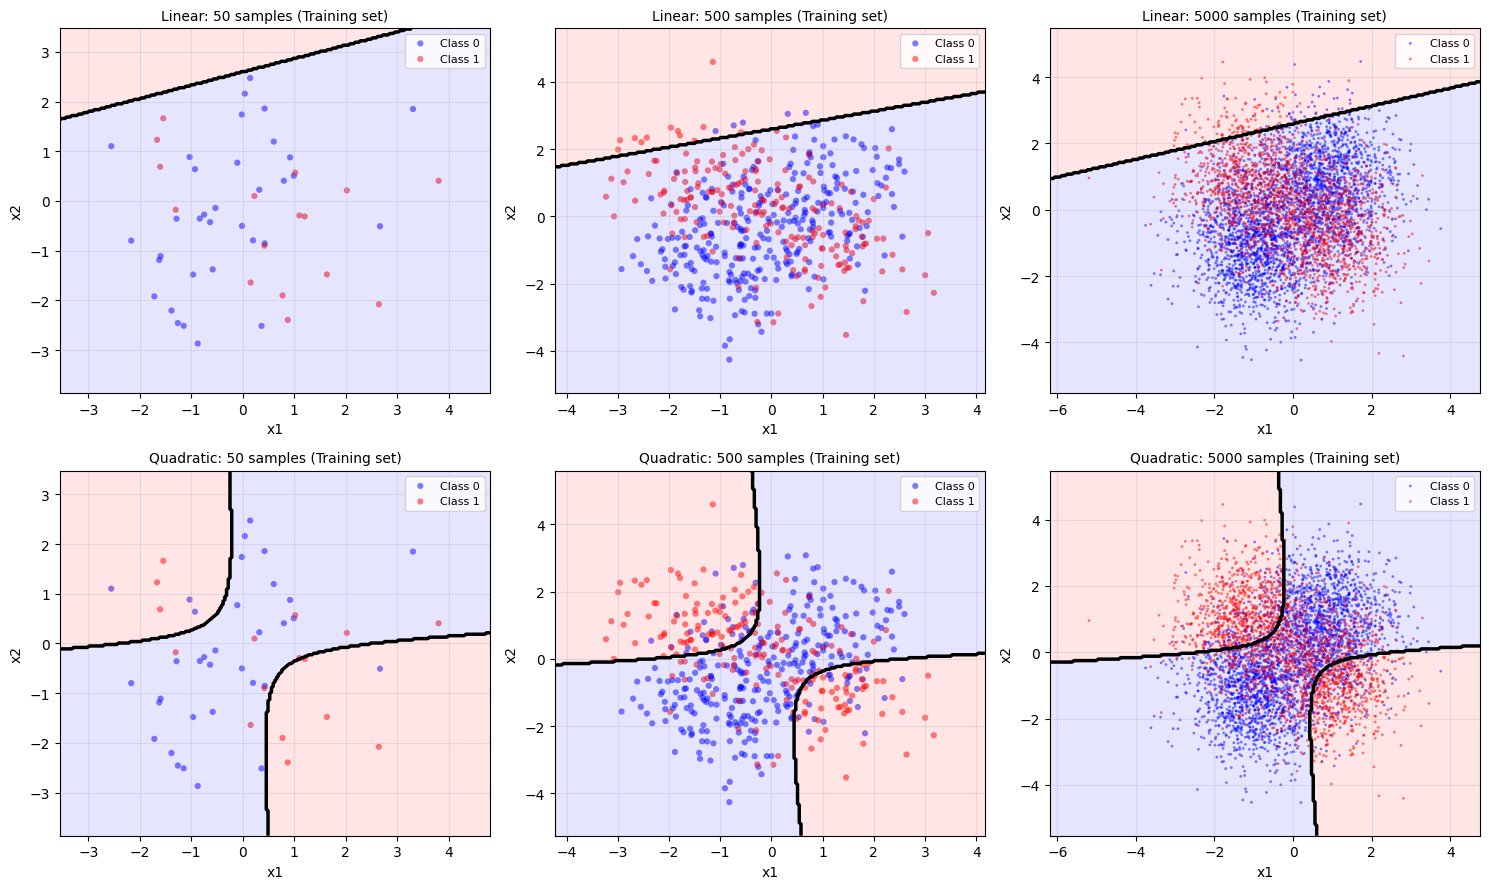

In [13]:
# Plot on training sets
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Loop over samples
for idx, train_name in enumerate(['50', '500', '5000']):
    # Loop over models
    for row, model_name in enumerate(['Linear', 'Quadratic']):
        model, xTrain, yTrain = trained_models[(model_name, train_name)]
        x1r = [xTrain[:,0].min()-1, xTrain[:,0].max()+1]
        x2r = [xTrain[:,1].min()-1, xTrain[:,1].max()+1]
        plot_boundary(axes[row, idx], model, xTrain, yTrain, f'{model_name}: {train_name} samples (Training set)', x1r, x2r)
        
plt.tight_layout()
plt.show()

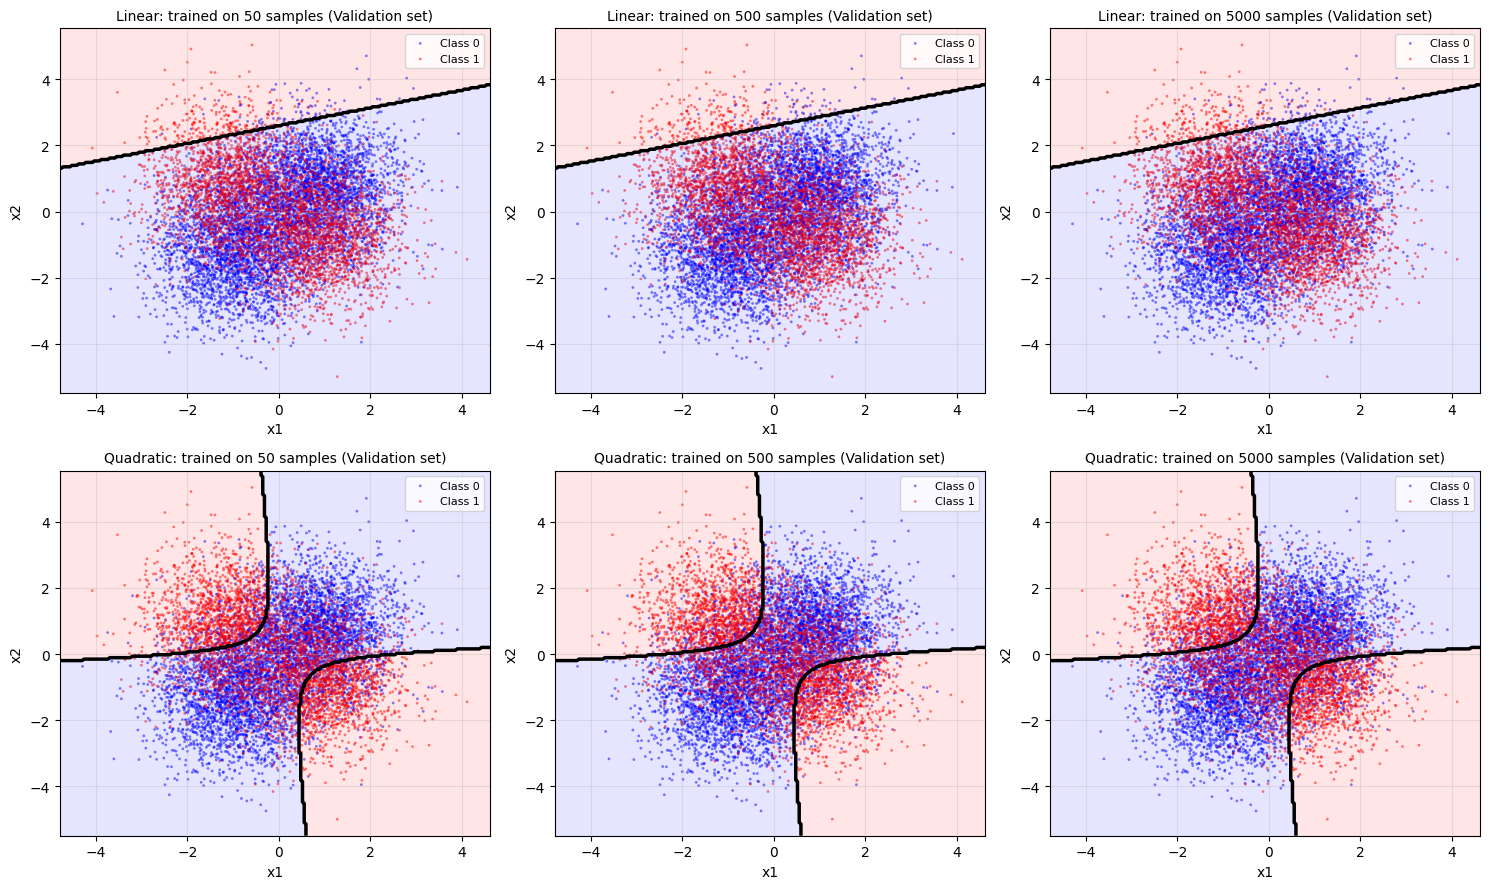

In [14]:
# Plot on validation set
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
x1r = [xValidate[:,0].min()-0.5, xValidate[:,0].max()+0.5]
x2r = [xValidate[:,1].min()-0.5, xValidate[:,1].max()+0.5]

# Loop over samples
for idx, train_name in enumerate(['50', '500', '5000']):
    # Loop over models
    for row, model_name in enumerate(['Linear', 'Quadratic']):
        model, _, _ = trained_models[(model_name, train_name)]
        plot_boundary(axes[row, idx], model, xValidate, yValidate, f'{model_name}: trained on {train_name} samples (Validation set)', x1r, x2r)

plt.tight_layout()
plt.show()